### Executive Summary

This report details the analysis of RNA-seq count data from matched normal and cancer liver tissues, specifically hepatocellular carcinoma (HCC). The study encompasses data preparation, differential gene expression analysis, feature selection, training a random forest model, and the evaluating the model's performance.

####  Datasets

- RNA-seq count data were obtained from The Cancer Genome Atlas (TCGA) for matched cancer and normal liver tissues.
- Samples comprised primary tumor and solid normal tissue from 72 donors with HCC.

#### Differential Gene Expression Analysis

- Conducted differential gene expression (DGE) analysis on half of the samples.
- A total of 304 genes were found to be significantly differentially expressed between cancer and normal tissues.

#### Feature Selection

- Identified the top 50 genes based on their importance in distinguishing cancer from normal tissue.

#### Model Training and Testing

- Partitioned the remaining samples into training and testing sets to evaluate a random forest model.
- The model achieved perfect classification performance in distinguishing between cancer and normal tissue samples.

- **Performance Metrics**:
  - **Accuracy**: 1.0 (100%).
  - **Sensitivity**: 1.0.
  - **Specificity**: 1.0.

The analysis successfully identified genes with significant differential expression and demonstrated a robust predictive model for distinguishing between cancer and normal liver tissue. These findings provide valuable insights for further research into biomarkers and potential therapeutic targets for HCC. If the performance of this model is replicated by indirectly measuring the expression of these genes using biomarkers found in blood, it could enable non-invasive diagnostic and monitoring of liver cancer, improving patient outcomes.

## Load Required Libraries

In [1]:
install_and_load <- function(packages) {
    if (!requireNamespace("BiocManager", quietly=T)) {
    install.packages("BiocManager", quiet=T)
    }
    
    for (package in bioconda_packages) {
        if (!require(package, character.only=T)) {
            BiocManager::install(package, quiet=T, force=T)
            require(package, character.only=T)
        }
    }
    
    for (package in cran_packages) {
        if (!require(package, character.only=T)) {
            install.packages(package, quiet=T, force=T)
            require(package, character.only=T)
        }
    }
}

bioconda_packages <- c("DESeq2", "BiocParallel")

cran_packages <- c("dplyr", "tidyverse", "caret", "randomForest")

suppressMessages(suppressWarnings(install_and_load(packages)))

## Load Datasets
- The dataset comprises RNA-seq count data for both cancerous and normal liver tissue obtained from The Cancer Genome Atlas (TCGA).
- It includes primary tumor and proximal solid normal tissue samples from 72 donors diagnosed with hepatocellular carcinoma.

### Sample Metadata and Gene Annotation

In [2]:
sample_data <- read.delim("gdc_sample_sheet.2024-06-22.tsv", sep="\t",
                          row.names=7)

metadata <- sample_data %>%
    select(-c(File.ID, File.Name, Data.Category, Data.Type, Project.ID)) %>%
    mutate_all(as.factor) %>%
    arrange(rownames(.))

head(metadata, 2)

annotation <- read.delim(paste0("counts/", sample_data[1, 2]), skip=1, row.names=1)[, 1:2]

tail(head(annotation, 6), 2)

,Case.ID,Sample.Type,Primary.Diagnosis,Age.At.Diagnosis,Vital.Status,Days.To.Death,Gender,Race,Ethnicity
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
TCGA-BC-A10Q-01A,TCGA-BC-A10Q,Primary Tumor,"Hepatocellular carcinoma, NOS",72 years 102 days,Dead,3 years 40 days,female,white,not hispanic or latino
TCGA-BC-A10Q-11A,TCGA-BC-A10Q,Solid Tissue Normal,"Hepatocellular carcinoma, NOS",72 years 102 days,Dead,3 years 40 days,female,white,not hispanic or latino


,gene_name,gene_type
,<chr>,<chr>
ENSG00000000003.15,TSPAN6,protein_coding
ENSG00000000005.6,TNMD,protein_coding


### Feature Counts
- Combined STAR-generated count data into a unified feature count matrix to facilitate downstream analysis.
- Verified that the column names of the `count_matrix` accurately corresponded to the row names of the `metadata`.

In [3]:
read_counts <- function(sample.ids){
    for(id in sample.ids){
        star_data <- read.delim(paste0("counts/", sample_data[id, "File.Name"]),
                                 skip=1, row.names=1) %>%
                        filter(!is.na(fpkm_unstranded))

        if(!exists("count_table")){
            count_table <- star_data %>%
                select(unstranded) %>%
                rename_with(~id, everything())
        } else {
        count_table <- cbind(count_table, star_data %>%
                             select(unstranded) %>%
                             rename_with(~id, everything()))
        }
    }
    
    count_table
}

count_data <- read_counts(rownames(metadata))

count_matrix <- as.matrix(count_data)

head(count_matrix, 4)

all(colnames(count_matrix)==rownames(metadata))

,TCGA-BC-A10Q-01A,TCGA-BC-A10Q-11A,TCGA-BC-A10R-01A,TCGA-BC-A10R-11A,TCGA-BC-A10T-01A,TCGA-BC-A10T-11A,TCGA-BC-A10U-01A,TCGA-BC-A10U-11A,TCGA-BC-A10W-01A,TCGA-BC-A10W-11A,⋯,TCGA-FV-A23B-01A,TCGA-FV-A23B-11A,TCGA-FV-A2QR-01A,TCGA-FV-A2QR-11A,TCGA-FV-A3I0-01A,TCGA-FV-A3I0-11A,TCGA-FV-A3I1-01A,TCGA-FV-A3I1-11A,TCGA-ZU-A8S4-01A,TCGA-ZU-A8S4-11A
ENSG00000000003.15,1269,4303,5714,4347,3976,3231,16882,4577,4008,4845,⋯,13636,6196,8836,4393,16693,3957,7225,3722,1900,4088
ENSG00000000005.6,0,1,2,22,2,0,0,0,1,1,⋯,6,3,0,0,0,0,0,1,0,0
ENSG00000000419.13,1396,802,2062,1032,2191,693,1305,1075,2124,975,⋯,2096,1073,1454,1028,1419,873,866,698,1578,740
ENSG00000000457.14,496,411,1012,649,767,514,1041,566,2940,277,⋯,743,564,777,431,543,316,673,440,359,261


[1] TRUE

## Differential Gene Expression Analysis
- Performed Differential Gene Expression (DGE) analysis using half of the available samples.
- Contrasted `Primary Tumor` samples with `Solid Tissue Normal` samples to identify differentially expressed genes.
- Filtered out genes with very low counts, specifically those with fewer than 10 features in at least one group.
- Identified a total of 45 genes (1.4%) that were upregulated and 259 genes (4.5%) that were downregulated.

In [4]:
set.seed(1500)

deg_samples <- sample(seq_len(nrow(metadata)), size=round(nrow(metadata)/2, 0))

deg_counts <- count_matrix[ , deg_samples]

deg_metadata <- metadata[deg_samples, ]

groups <- deg_metadata %>%
    mutate(Sample.Type=factor(gsub(" ", "_", Sample.Type),
                              levels=c("Solid_Tissue_Normal", "Primary_Tumor")),
           Case.ID=factor(gsub("-", "_", Case.ID)))

dds_data <- DESeqDataSetFromMatrix(countData=deg_counts,
                              colData=groups,
                              design=~Case.ID+Sample.Type)

register(MulticoreParam(6))

dds <- DESeq(dds_data, parallel=T, quiet=T)

keep <- rowSums(counts(dds)>=10)>=min(table(deg_metadata$Sample.Type)) #adjust cutoffs

dds <- dds[keep, ]

res <- results(dds, lfcThreshold=2, alpha=0.05) #adjust cutoffs

summary(res)


out of 17201 with nonzero total read count
adjusted p-value < 0.05
LFC > 2.00 (up)    : 45, 0.26%
LFC < -2.00 (down) : 259, 1.5%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 8)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



### Selected Significantly Upregulation and Downregulated Genes
- Identified genes with greater than 4-fold upregulation or downregulation and an adjusted *p-value* of less than 0.05.
- In total, 304 genes were found to be significantly differentially expressed between cancer and normal samples.

In [5]:
sig_table <- res %>%
    as.data.frame() %>%
    arrange(-abs(log2FoldChange)) %>%
    filter(abs(log2FoldChange)>2, padj<0.05) #adjust cutoffs

sig_genes <- unique(row.names(sig_table))

length(sig_genes)

[1] 304

- Used VST-normalized count data for downstream analyses.

In [6]:
normalised_count <- assay(vst(dds, blind=F))

filtered_count <- normalised_count[sig_genes, ]

## Feature Selection
- Applied a random forest algorithm to identify the top 50 genes based on their importance in distinguishing between cancer and normal tissue.
- These top genes were prioritized for further analysis and validation due to their significant predictive power and potential biological relevance.

In [7]:
set.seed(1500)

expression_matrix <- log2(filtered_count + 1)
expression_matrix <- t(scale(t(expression_matrix)))

combined_data <- t(expression_matrix) %>%
  as.data.frame() %>%
  rownames_to_column(var="Sample") %>%
  left_join(metadata %>% rownames_to_column("Sample"), "Sample")

response_variables <- combined_data %>%
  select(Sample.Type) %>%
  mutate(across(everything(), as.factor))

predictors <- combined_data %>%
  select(-Sample, -where(is.character), -where(is.factor))

rf_models <- lapply(names(response_variables), function(response_var) {
  randomForest(response_variables[[response_var]] ~ ., data=predictors, importance=T)
})

important_features_list <- lapply(rf_models, function(model) {
  importance <- as.data.frame(importance(model))
  importance <- importance[order(importance$MeanDecreaseGini, decreasing=T), ]
  rownames(importance)[1:50]  #adjust the number of top features
})

all_important_features <- unique(unlist(important_features_list))

filtered_expression_matrix <- normalised_count[all_important_features, ]

### Visualized Gene Expression and Adjusted *p-values* for Selected Features
- Used jitter plots to highlight the differences in gene expression levels and adjusted *p-values* between cancer and normal tissue groups, as well as to show the similarities within each group.

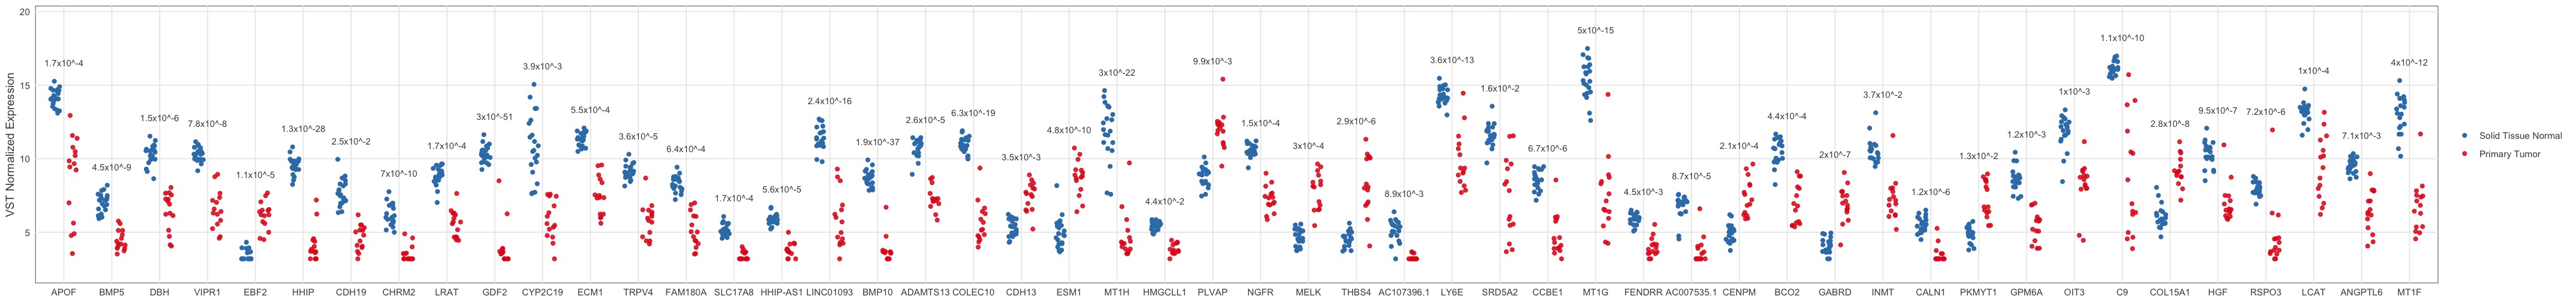

In [ ]:
options(repr.plot.width=34, repr.plot.height=4)

filtered_expression_matrix %>%
    as.data.frame() %>%
    rownames_to_column(var="Symbol") %>%
    gather(2:(length(rownames(deg_metadata))+1), key="Case",
           value="VST Normalized Expression") %>%
    mutate(gene_id=factor(annotation[Symbol, "gene_name"],
                          levels=annotation[all_important_features, "gene_name"]),
           `Sample Type`=factor(sample_data[Case, "Sample.Type"],
                                levels=c("Solid Tissue Normal", "Primary Tumor"))) %>%
    group_by(`Sample Type`, gene_id) %>%
    ggplot(aes(y=`VST Normalized Expression`, x=gene_id,
               col=`Sample Type`)) +
        scale_y_continuous(expand=c(0.1,0.1)) +
        geom_jitter(position=position_jitterdodge()) +
        geom_text(data=filtered_expression_matrix %>%
                  as.data.frame() %>%
                  rownames_to_column(var="Symbol"),
                  aes(label=paste0(round((res[Symbol, "padj"]/
                                          (10^floor(log10(abs(res[Symbol, "padj"]))))), 1),
                                   "x10^",
                                   floor(log10(abs(res[Symbol, "padj"])))),
                      x=annotation[Symbol, "gene_name"],
                  y=rowMax(filtered_expression_matrix)+1.25),
                  hjust=0.5, color="grey30", size=3) +
        scale_color_manual(values=c("#377eb8ff", "#e3221cdd"))+
        theme_minimal() +
        theme(legend.title=element_blank(),
              panel.background=element_rect(fill=NA, color="grey30"),
              panel.grid.minor=element_blank(),
              text=element_text(size=11, color="grey30"),
              axis.title.x=element_blank())

## Model Training and Testing
- Partitioned the remaining samples into training and testing sets to build and evaluate the random forest model.
- The model achieved perfect classification performance on the test set, indicating high sensitivity and specificity in distinguishing between Solid Tissue Normal and Primary Tumor samples.
- Summary of performance metrics:
    - Confusion Matrix:
        - Correctly classified 12 `Primary_Tumor` samples.
        - Correctly classified 9 `Solid_Tissue_Normal` samples.
    - Accuracy: 1.0 (100%).
    - Sensitivity: 1.0.
    - Specificity: 1.0.

In [9]:
set.seed(1500)

remaining_counts <- count_matrix[all_important_features , -deg_samples]

remaining_metadata <- metadata[-deg_samples, ]

remaining_metadata <- remaining_metadata %>%
    mutate(Sample.Type=factor(gsub(" ", "_", Sample.Type),
                              levels=c("Primary_Tumor", "Solid_Tissue_Normal")),
           Case.ID=factor(gsub("-", "_", Case.ID)))

dds_data <- DESeqDataSetFromMatrix(countData=remaining_counts,
                              colData=remaining_metadata,
                              design=~Case.ID+Sample.Type)

remaining_data <- assay(dds_data, blind=F)

train_index <- createDataPartition(y=remaining_metadata$Sample.Type, p=0.4, list=FALSE)

train_data <- remaining_data[, train_index]
test_data <- remaining_data[, -train_index]

train_labels <- remaining_metadata$Sample.Type[train_index]
test_labels <- remaining_metadata$Sample.Type[-train_index]

rf_model <- randomForest(x = t(train_data), y = train_labels)
rf_predictions <- predict(rf_model, t(test_data))

confusionMatrix(rf_predictions, test_labels)

Confusion Matrix and Statistics

                     Reference
Prediction            Primary_Tumor Solid_Tissue_Normal
  Primary_Tumor                  12                   0
  Solid_Tissue_Normal             0                   9
                                       
               Accuracy : 1            
                 95% CI : (0.8389, 1)  
    No Information Rate : 0.5714       
    P-Value [Acc > NIR] : 7.874e-06    
                                       
                  Kappa : 1            
                                       
 Mcnemar's Test P-Value : NA           
                                       
            Sensitivity : 1.0000       
            Specificity : 1.0000       
         Pos Pred Value : 1.0000       
         Neg Pred Value : 1.0000       
             Prevalence : 0.5714       
         Detection Rate : 0.5714       
   Detection Prevalence : 0.5714       
      Balanced Accuracy : 1.0000       
                                       
       '